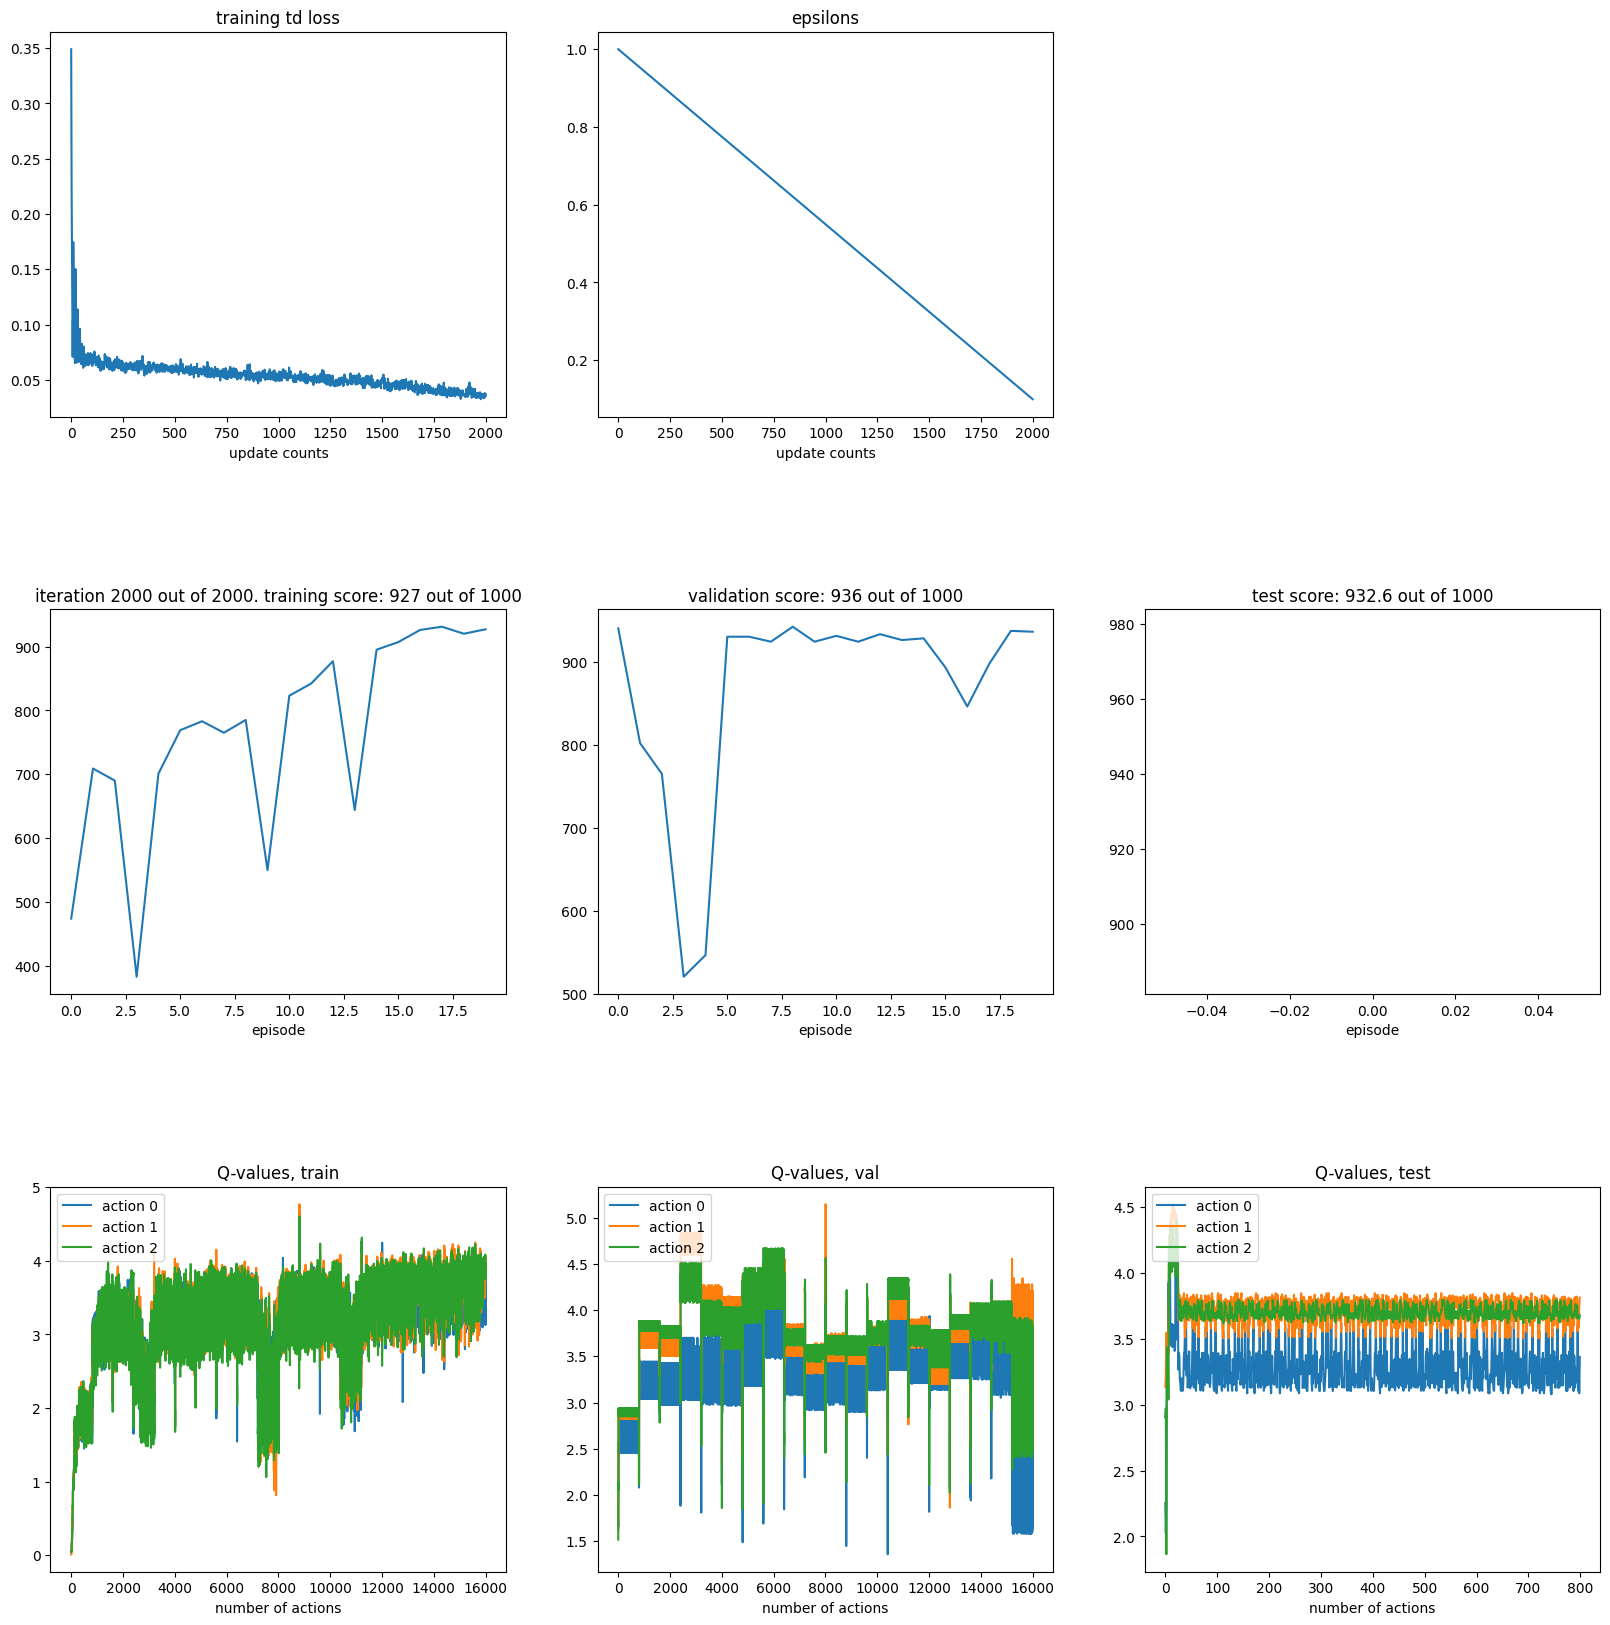

In [1]:
%matplotlib inline
from agent import HandcraftedAgent
from tqdm.auto import tqdm
import numpy as np
import random
import logging
from room_env.envs.room2 import RoomEnv2

logger = logging.getLogger()
logger.disabled = True


for room_size in ["xl", "l", "m", "s", "xs", "xxs"]:

    if room_size == "xxs":
        mem_size = 2
    elif room_size == "xs":
        mem_size = 4
    elif room_size == "s":
        mem_size = 8
    elif room_size == "m":
        mem_size = 16
    elif room_size == "l":
        mem_size = 32
    elif room_size == "xl":
        mem_size = 64

    capacity = {
        "episodic": mem_size,
        "episodic_agent": 0,
        "semantic": mem_size,
        "semantic_map": 0,
        "short": 1,
    }

    config = {
        "question_prob": 1.0,
        "terminates_at": 99,
        "randomize_observations": True,
        "room_size": room_size,
        "rewards": {"correct": 1, "wrong": 0, "partial": 0},
        "make_everything_static": False,
        "num_total_questions": 1000,
        "question_interval": 1,
            
    }

    results = {}

    for mm_policy in ["random", "episodic", "semantic"]:
        for qa_policy in ["episodic_semantic"]:
            for explore_policy in ["avoid_walls", "random"]:
                for pretrain_semantic in [False]:
                    key = (
                        mm_policy,
                        qa_policy,
                        explore_policy,
                        pretrain_semantic,
                    )
                    if key not in results:
                        results[key] = []
                    print(key)

                    for seed in tqdm([0, 1, 2, 3, 4]):
                        agent = HandcraftedAgent(
                            env_str="room_env:RoomEnv-v2",
                            env_config={**config, "seed": seed},
                            mm_policy=mm_policy,
                            qa_policy=qa_policy,
                            explore_policy=explore_policy,
                            num_samples_for_results=10,
                            capacity=capacity,
                            pretrain_semantic=pretrain_semantic,
                            default_root_dir="./training_results/TRASH",
                        )
                        agent.test()
                        agent.remove_results_from_disk()
                        to_append = (np.mean(agent.scores), np.std(agent.scores))
                        # print(to_append)
                        results[key].append(to_append)


    env = RoomEnv2(**config)
    observations, info = env.reset()
    env.render("image")
    for key, val in env.names.items():
        print(f"The number of {key}: {len(val)}")

    print(
        f"\n{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
    )
    print(f"-" * 110)
    for key, val in results.items():
        print(
            f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
        )


    from agent.dqn import DQNMMAgent
    from tqdm.auto import tqdm
    import random
    import logging

    logger = logging.getLogger()
    logger.disabled = True


    params = {
        "env_str": "room_env:RoomEnv-v2",
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "epsilon_decay_until": 100 * 20,
        "gamma": 0.7,
        "capacity": capacity,
        "nn_params": {
            "hidden_size": 128,
            "num_layers": 2,
            "embedding_dim": 64,
            "v1_params": None,
            "v2_params": {},
            "memory_of_interest": [
                "episodic",
                "semantic",
                "short",
            ],
        },
        "num_iterations": 100 * 20,
        "replay_buffer_size": 32768,
        "warm_start": 4096,
        "batch_size": 1024,
        "target_update_interval": 10,
        "pretrain_semantic": False,
        "run_test": True,
        "num_samples_for_results": 10,
        "train_seed": 5,
        "plotting_interval": 10,
        "device": "cpu",
        "test_seed": 0,
        "qa_policy": "episodic_semantic",
        "explore_policy": "avoid_walls",
        "env_config": config,
        "ddqn": True,
        "dueling_dqn": True,
        "split_reward_training": True,
        "default_root_dir": "./training_results/TRASH",
    }

    agent = DQNMMAgent(**params)
    agent.train()